### **IMPORT**

In [ ]:
# Common imports
import numpy as np
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf


from sklearn.metrics import f1_score, recall_score, precision_score


from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.callbacks import Callback
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
from keras import backend as K


import copy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
import keras
import numpy as np
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras.layers import SpatialDropout2D
from keras import regularizers
import matplotlib.pyplot as plt

### **DROPBLOCK FUNCTION**
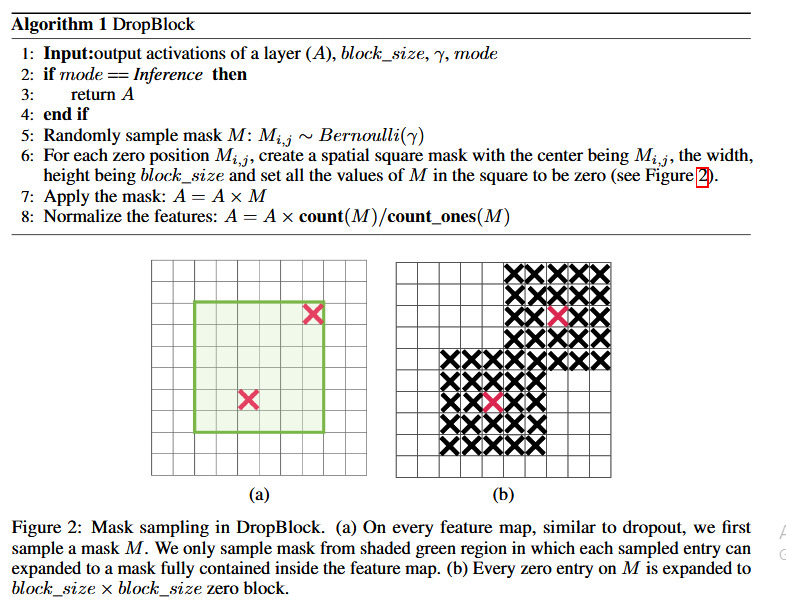


In [ ]:
from keras import backend as K


import copy

class NN_DropBlock(tf.keras.layers.Layer):

    def __init__(self, block_size, keep_prob, **kwargs):
        super(NN_DropBlock, self).__init__(**kwargs)
        self.block_size = block_size
        self.keep_prob = keep_prob

    def call(self, x, inference=None):

        # During inference, we do not Drop Blocks
        if inference == None:
            return x

        #padding
        z = self.block_size//2

        # Calculate Gamma
        feature_size = int(x.shape[-1])
        gamma = ((1-self.keep_prob)/(self.block_size**2)) * ((feature_size**2) / ((feature_size-self.block_size+1)**2))

        # Randomly sample mask
        sample_mask = tf.nn.relu(tf.sign(gamma - tf.random_uniform((feature_size-(z*2), feature_size-(z*2)), minval=0, maxval=1, dtype=tf.float32)))

        # The above code creates a matrix of zeros and samples ones from the distribution
        # We would like to flip all of these values
        sample_mask = 1-sample_mask

        # Pad the mask with ones
        sample_mask = np.pad(sample_mask, pad_width=z, mode='constant', constant_values=1)

        # For each 0, create spatial square mask of shape (block_size x block_size)
        spatial_square_mask = copy.copy(sample_mask)
        for i in range(feature_size):
            for j in range(feature_size):
                if sample_mask[i, j]==0:
                    spatial_square_mask[i-z : i+z+1, j-z : j+z+1] = 0

        spatial_square_mask = spatial_square_mask.reshape((1, feature_size, feature_size))

        # Apply the mask
        x = x * np.repeat(spatial_square_mask, x.shape[1], 0)

        # Normalize the features
        count = np.prod(spatial_square_mask.shape)
        count_ones = np.count_nonzero(spatial_square_mask == 1)
        x = x * count / count_ones

        return x

    def get_config(self):
        config = {'block_size': self.block_size,
                  'keep_prob': self.keep_prob
                  }
        base_config = super(NN_DropBlock, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

### **CALLBACK FUNCTION**

In [ ]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch,logs={}):
        for i in range(118):
          s = str(i)
          # vary the rate wrt epochs. That's what you want
          self.model.get_layer(name = s).keep_prob -= 0.066666667
    

### **DENSENET STANDARD**

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 7, 7, 64)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 7, 64)     256         max_pooling2d[0][0]              
_____________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
469/469 [==============================] - 147s 141ms/step - loss: 0.4979 - accuracy: 0.8512 - val_loss: 0.5355 - val_accuracy: 0.8212
Epoch 2/10
469/469 [==============================] - 55s 117ms/step - loss: 0.0513 - accuracy: 0.9838 - val_loss: 0.0643 - val_accuracy: 0.9794
Epoch 3/10
469/469 [==============================] - 54s 116ms/step - loss: 0.0276 - accuracy: 0.9913 - val_loss: 0.0463 - val_accuracy: 0.9862
Epoch 4/10
469/469 [==============================] - 54s 115ms/step - loss: 0.0193 - accuracy: 0.9933 - val_loss: 0.1259 - val_accuracy: 0.9672
Epoch 5/10
469/469 [==============================] - 55s 117ms/step - loss: 0.0142 - accuracy: 0.9950 - val_loss: 0.0485 - val_accuracy: 0.9866
Epoch 6/10
469/469 [==============================] - 56s 119ms/step - loss: 0.0138 - accuracy: 0.9958 - val_loss: 0.0392 - val_accuracy: 0.9897
Epoch 7/10
469/469 [==============================] - 56s 118ms/step - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.0518 - val_a

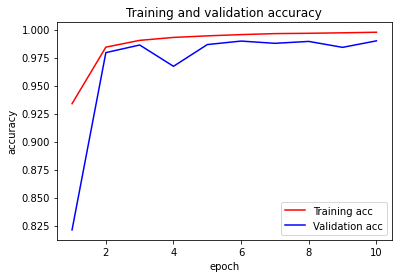

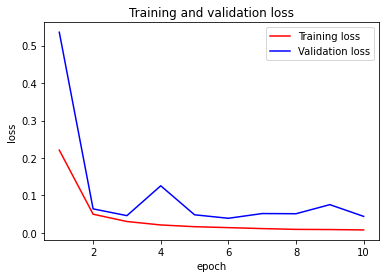

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np



def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16

  def bn_rl_conv( x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

batch_size = 128
epochs = 10
num_classes = 10

# input image dimension
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first': # I want this shape: num_samples x 1 x 28 x 28
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # I want this shape: num_samples x 28 x 28 x 1
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = densenet(input_shape, num_classes)
model.summary()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True
              )

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

print(acc1)
print(val_acc1)
print(loss1)
print(val_loss1)

epochs = range(1, len(acc1) + 1)

plt.plot(epochs, acc1, 'r', label='Training acc')
plt.plot(epochs, val_acc1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss1, 'r', label='Training loss')
plt.plot(epochs, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **DROPOUT(0.25)**

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 14, 14, 64)   3200        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 7, 7, 64)     0           conv2d_121[0][0]                 
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 7, 7, 64)     256         max_pooling2d_1[0][0]            
___________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
469/469 [==============================] - 126s 154ms/step - loss: 1.6829 - accuracy: 0.3937 - val_loss: 13.7140 - val_accuracy: 0.1135
Epoch 2/10
469/469 [==============================] - 61s 130ms/step - loss: 0.3003 - accuracy: 0.9041 - val_loss: 0.2677 - val_accuracy: 0.9260
Epoch 3/10
469/469 [==============================] - 61s 129ms/step - loss: 0.1680 - accuracy: 0.9465 - val_loss: 0.1341 - val_accuracy: 0.9648
Epoch 4/10
469/469 [==============================] - 61s 130ms/step - loss: 0.1240 - accuracy: 0.9609 - val_loss: 0.0763 - val_accuracy: 0.9779
Epoch 5/10
469/469 [==============================] - 60s 128ms/step - loss: 0.1009 - accuracy: 0.9680 - val_loss: 0.0640 - val_accuracy: 0.9820
Epoch 6/10
469/469 [==============================] - 61s 130ms/step - loss: 0.0863 - accuracy: 0.9727 - val_loss: 0.0601 - val_accuracy: 0.9817
Epoch 7/10
469/469 [==============================] - 61s 130ms/step - loss: 0.0713 - accuracy: 0.9770 - val_loss: 0.0459 - val_

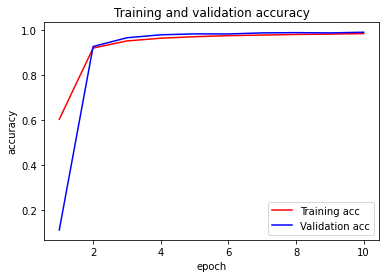

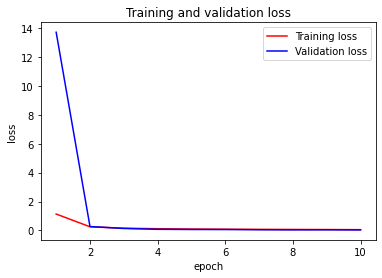

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np



def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16

  def bn_rl_conv( x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.25)(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

batch_size = 128
epochs = 10
num_classes = 10

# input image dimension
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first': # I want this shape: num_samples x 1 x 28 x 28
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # I want this shape: num_samples x 28 x 28 x 1
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = densenet(input_shape, num_classes)
model.summary()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True
              )

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

print(acc2)
print(val_acc2)
print(loss2)
print(val_loss2)

epochs = range(1, len(acc2) + 1)

plt.plot(epochs, acc2, 'r', label='Training acc')
plt.plot(epochs, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss2, 'r', label='Training loss')
plt.plot(epochs, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **SPATIAL(0.3)**

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_242 (Conv2D)             (None, 14, 14, 64)   3200        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 7, 7, 64)     0           conv2d_242[0][0]                 
__________________________________________________________________________________________________
batch_normalization_240 (BatchN (None, 7, 7, 64)     256         max_pooling2d_2[0][0]            
___________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
469/469 [==============================] - 134s 164ms/step - loss: 2.1292 - accuracy: 0.2233 - val_loss: 11.2759 - val_accuracy: 0.1135
Epoch 2/10
469/469 [==============================] - 64s 136ms/step - loss: 0.9713 - accuracy: 0.6645 - val_loss: 1.1289 - val_accuracy: 0.6870
Epoch 3/10
469/469 [==============================] - 63s 134ms/step - loss: 0.3943 - accuracy: 0.8757 - val_loss: 0.3073 - val_accuracy: 0.9158
Epoch 4/10
469/469 [==============================] - 63s 135ms/step - loss: 0.2448 - accuracy: 0.9238 - val_loss: 0.1665 - val_accuracy: 0.9544
Epoch 5/10
469/469 [==============================] - 63s 134ms/step - loss: 0.1906 - accuracy: 0.9411 - val_loss: 0.1270 - val_accuracy: 0.9633
Epoch 6/10
469/469 [==============================] - 63s 134ms/step - loss: 0.1595 - accuracy: 0.9512 - val_loss: 0.1078 - val_accuracy: 0.9705
Epoch 7/10
469/469 [==============================] - 64s 136ms/step - loss: 0.1353 - accuracy: 0.9572 - val_loss: 0.0926 - val_

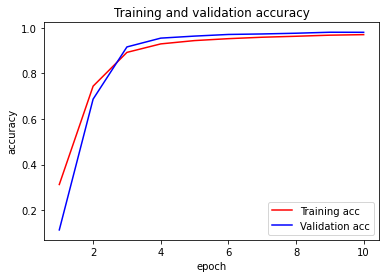

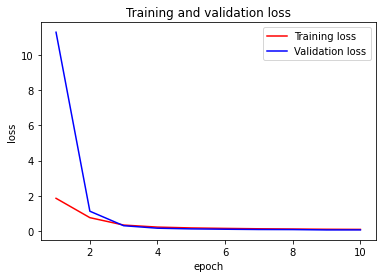

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np



def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16

  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout2D(0.3)(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model


batch_size = 128
epochs = 10
num_classes = 10

# input image dimension
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first': # I want this shape: num_samples x 1 x 28 x 28
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # I want this shape: num_samples x 28 x 28 x 1
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = densenet(input_shape, num_classes)
model.summary()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True
              )

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc3 = history.history['accuracy']
val_acc3 = history.history['val_accuracy']
loss3 = history.history['loss']
val_loss3 = history.history['val_loss']

print(acc3)
print(val_acc3)
print(loss3)
print(val_loss3)

epochs = range(1, len(acc3) + 1)

plt.plot(epochs, acc3, 'r', label='Training acc')
plt.plot(epochs, val_acc3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss3, 'r', label='Training loss')
plt.plot(epochs, val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **DROPBLOCK**

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_363 (Conv2D)             (None, 14, 14, 64)   3200        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 7, 7, 64)     0           conv2d_363[0][0]                 
__________________________________________________________________________________________________
batch_normalization_360 (BatchN (None, 7, 7, 64)     256         max_pooling2d_3[0][0]            
___________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return py_builtins.overload_of(f)(*args)


469/469 [==============================] - 233s 245ms/step - loss: 1.0978 - accuracy: 0.6203 - val_loss: 5.0240 - val_accuracy: 0.2246
Epoch 2/10
469/469 [==============================] - 102s 218ms/step - loss: 0.1527 - accuracy: 0.9492 - val_loss: 0.0677 - val_accuracy: 0.9792
Epoch 3/10
469/469 [==============================] - 103s 220ms/step - loss: 0.0959 - accuracy: 0.9688 - val_loss: 0.0500 - val_accuracy: 0.9842
Epoch 4/10
469/469 [==============================] - 102s 218ms/step - loss: 0.0760 - accuracy: 0.9759 - val_loss: 0.0439 - val_accuracy: 0.9856
Epoch 5/10
469/469 [==============================] - 101s 215ms/step - loss: 0.0620 - accuracy: 0.9789 - val_loss: 0.0371 - val_accuracy: 0.9889
Epoch 6/10
469/469 [==============================] - 101s 215ms/step - loss: 0.0562 - accuracy: 0.9828 - val_loss: 0.0379 - val_accuracy: 0.9885
Epoch 7/10
469/469 [==============================] - 102s 217ms/step - loss: 0.0424 - accuracy: 0.9868 - val_loss: 0.0334 - val_accura

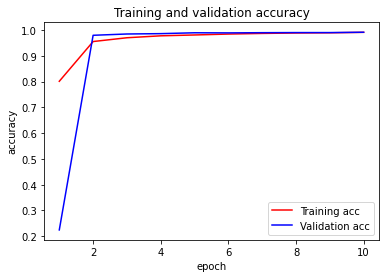

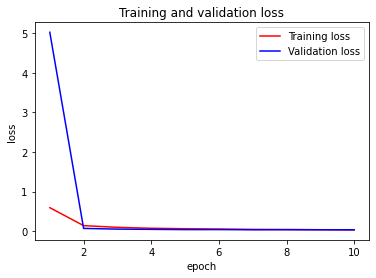

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np



def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  c = [0]

  def bn_rl_conv( c, x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = NN_DropBlock(block_size= 3, keep_prob = 0.9, name = str(c[0]))(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    c[0] = c[0]+1
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(c, tensor, 4*f)
      x = bn_rl_conv(c, x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(c, x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model


batch_size = 128
epochs = 10
num_classes = 10

# input image dimension
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first': # I want this shape: num_samples x 1 x 28 x 28
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # I want this shape: num_samples x 28 x 28 x 1
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = densenet(input_shape, num_classes)
model.summary()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks = myCallback())

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc4 = history.history['accuracy']
val_acc4 = history.history['val_accuracy']
loss4 = history.history['loss']
val_loss4 = history.history['val_loss']

print(acc4)
print(val_acc4)
print(loss4)
print(val_loss4)

epochs = range(1, len(acc4) + 1)

print(epochs)

plt.plot(epochs, acc4, 'r', label='Training acc')
plt.plot(epochs, val_acc4, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss4, 'r', label='Training loss')
plt.plot(epochs, val_loss4, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **DROPBLOCK 7**

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_484 (Conv2D)             (None, 14, 14, 64)   3200        input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 7, 7, 64)     0           conv2d_484[0][0]                 
__________________________________________________________________________________________________
batch_normalization_480 (BatchN (None, 7, 7, 64)     256         max_pooling2d_4[0][0]            
___________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return py_builtins.overload_of(f)(*args)


469/469 [==============================] - 247s 277ms/step - loss: 0.9310 - accuracy: 0.6847 - val_loss: 0.8895 - val_accuracy: 0.6897
Epoch 2/10
469/469 [==============================] - 117s 249ms/step - loss: 0.1135 - accuracy: 0.9639 - val_loss: 0.0517 - val_accuracy: 0.9819
Epoch 3/10
469/469 [==============================] - 117s 249ms/step - loss: 0.0678 - accuracy: 0.9786 - val_loss: 0.0366 - val_accuracy: 0.9866
Epoch 4/10
469/469 [==============================] - 117s 250ms/step - loss: 0.0495 - accuracy: 0.9844 - val_loss: 0.0310 - val_accuracy: 0.9900
Epoch 5/10
469/469 [==============================] - 118s 251ms/step - loss: 0.0369 - accuracy: 0.9881 - val_loss: 0.0279 - val_accuracy: 0.9905
Epoch 6/10
469/469 [==============================] - 117s 249ms/step - loss: 0.0311 - accuracy: 0.9904 - val_loss: 0.0345 - val_accuracy: 0.9889
Epoch 7/10
469/469 [==============================] - 117s 249ms/step - loss: 0.0276 - accuracy: 0.9914 - val_loss: 0.0272 - val_accura

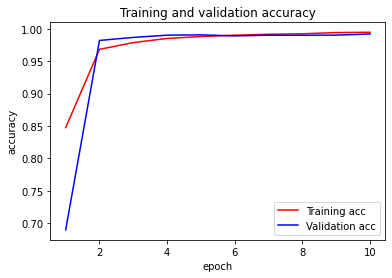

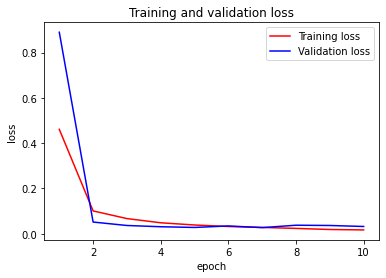

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np



def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  c = [0]

  def bn_rl_conv( c, x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = NN_DropBlock(block_size= 7, keep_prob = 0.9, name = str(c[0]))(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    c[0] = c[0]+1
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(c, tensor, 4*f)
      x = bn_rl_conv(c, x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(c, x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model


batch_size = 128
epochs = 10
num_classes = 10

# input image dimension
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first': # I want this shape: num_samples x 1 x 28 x 28
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # I want this shape: num_samples x 28 x 28 x 1
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = densenet(input_shape, num_classes)
model.summary()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks = myCallback())

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc5 = history.history['accuracy']
val_acc5 = history.history['val_accuracy']
loss5 = history.history['loss']
val_loss5 = history.history['val_loss']

print(acc5)
print(val_acc5)
print(loss5)
print(val_loss5)

epochs = range(1, len(acc5) + 1)

print(epochs)

plt.plot(epochs, acc5, 'r', label='Training acc')
plt.plot(epochs, val_acc5, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss5, 'r', label='Training loss')
plt.plot(epochs, val_loss5, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **MERGE RESULTS**

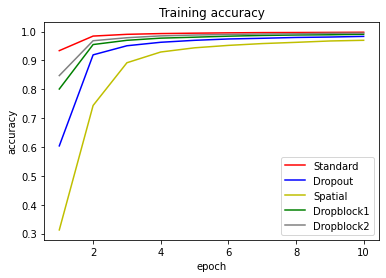

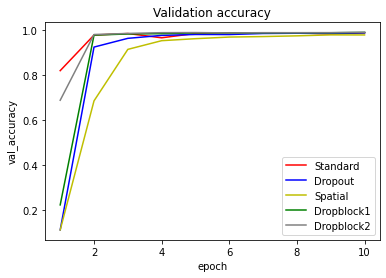

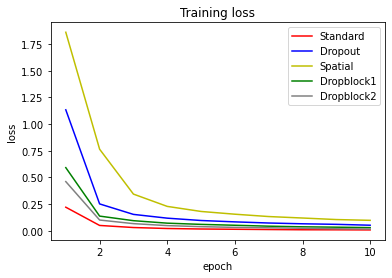

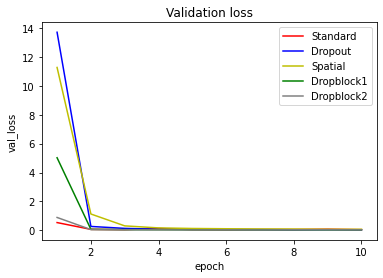

In [ ]:
plt.plot(epochs, acc1, 'r', label='Standard')
plt.plot(epochs, acc2, 'b', label='Dropout')
plt.plot(epochs, acc3, 'y', label='Spatial')
plt.plot(epochs, acc4, 'g', label='Dropblock1')
plt.plot(epochs, acc5, 'grey', label='Dropblock2')
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(epochs, val_acc1, 'r', label='Standard')
plt.plot(epochs, val_acc2, 'b', label='Dropout')
plt.plot(epochs, val_acc3, 'y', label='Spatial')
plt.plot(epochs, val_acc4, 'g', label='Dropblock1')
plt.plot(epochs, val_acc5, 'grey', label='Dropblock2')
plt.title('Validation accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


plt.plot(epochs, loss1, 'r', label='Standard')
plt.plot(epochs, loss2, 'b', label='Dropout')
plt.plot(epochs, loss3, 'y', label='Spatial')
plt.plot(epochs, loss4, 'g', label='Dropblock1')
plt.plot(epochs, loss5, 'grey', label='Dropblock2')
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(epochs, val_loss1, 'r', label='Standard')
plt.plot(epochs, val_loss2, 'b', label='Dropout')
plt.plot(epochs, val_loss3, 'y', label='Spatial')
plt.plot(epochs, val_loss4, 'g', label='Dropblock1')
plt.plot(epochs, val_loss5, 'grey', label='Dropblock2')
plt.title('Validation loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()